# Appendix I

## HW3 - Analyzing Cell Cluster Data With Random Forest

### By Alexander Pena

#### Assisted by: Ted

# Library imports

In [1]:
import os
import warnings
from IPython import display
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

# Data

## Data Import

First will look at the e1_positive.csv dataset

In [2]:
df = pd.read_csv("i1 positive.csv")
df

,GABRG2,CELF4,SRRM4,SLC1A3,ATP1A3,RBFOX3,GABRA4,NHSL1,GRAMD3,SEZ6L2,...,FERMT1,CSPG4,GJA1,LAMA1,YAP1,LINC00639.2,SMOC1,LINC00498,GFRA1,Label
0,35.038262,161.176004,68.074337,58.063405,20.021864,269.294069,188.205520,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.001093,0.0,0.0,0
1,95.324867,75.256474,87.297510,0.000000,18.061554,342.166102,683.328784,0.000000,0.0,1.003420,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.003420,0.0,0.0,0
2,220.143867,187.976727,42.219372,106.553653,0.000000,187.976727,299.556496,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,7.036562,0.000000,0.0,0.0,0
3,166.010840,26.159284,61.373704,0.000000,30.183789,254.549955,446.720079,0.000000,0.0,25.153158,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.006126,0.0,0.0,0
4,188.426220,71.160966,119.269788,57.129226,16.036274,265.600789,287.650666,24.054411,0.0,1.002267,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,665.606813,101.002551,4.040102,0.000000,95.952424,10.100255,79.792016,0.000000,0.0,192.914873,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.010026,0.0,0.0,0
867,21.157688,45.337903,18.135161,1.007509,290.162582,14.105125,0.000000,3.022527,0.0,64.480574,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0
868,4.111466,81.201453,1704.202638,2.055733,9.250798,75.034254,238.465025,1.027866,0.0,1.027866,...,0.0,0.0,0.0,0.0,0.0,1.027866,0.000000,0.0,0.0,0
869,37.480576,438.624037,0.000000,0.000000,69.896209,3.038966,66.857244,0.000000,0.0,130.675522,...,0.0,0.0,0.0,0.0,0.0,0.000000,252.234146,0.0,0.0,0


## Dataset Characteristics

All the samples in the dataset are numeric

### Number of samples 

In [3]:
print('Number of samples:', df.shape[0])

Number of samples: 871


### Number of each label

In [4]:
print('Number of 0 labels: ', len(df[df.Label==0]))
print('Number of 1 labels: ', len(df[df.Label==1]))

Number of 0 labels:  781
Number of 1 labels:  90


### Datatype

### Range of Data

In [5]:
print('Biggest value in the dataset:', df.min().min())
print('Biggest value in the dataset:', df.max().max())
print('Mean of all the means:', df.mean().mean())
print('Standard Deviation of all the standard deviations:', df.std().std())

Biggest value in the dataset: 0.0
Biggest value in the dataset: 11405.4695
Mean of all the means: 56.448339872720446
Standard Deviation of all the standard deviations: 118.98586594987398


### How many values are just zeros?

In [6]:
vals = []
for index, row in df.iterrows():
    vals.append(row[row == 0].value_counts()[0])
num_zeroes = pd.Series(vals)
print('Mean number of zeroes between features:', num_zeroes.mean())
print('Standard Deviation of the number of zeroes between features:', num_zeroes.std())

Mean number of zeroes between features: 356.40872560275545
Standard Deviation of the number of zeroes between features: 53.02767108583817


### Checking Proportions of '0' Labels to '1' Labels in dataset

In [54]:
value_counts = df['Label'].value_counts()
print('Ratio of 0 to 1 is', value_counts[0]/value_counts[1])
print('Ratio of 1 to 0 is', value_counts[1]/value_counts[0])
print('Percent of 0 from total', value_counts[0]/df.shape[0])
print('Percent of 1 from total', value_counts[1]/df.shape[0])

print('Making sure the proportions add up to 1:')
value_counts[0]/df.shape[0] + value_counts[1]/df.shape[0]

Ratio of 0 to 1 is 8.677777777777777
Ratio of 1 to 0 is 0.11523687580025609
Percent of 0 from total 0.8966704936854191
Percent of 1 from total 0.10332950631458095
Making sure the proportions add up to 1:


1.0

## Data Cleaning

### Adding column of occurences

This is so we can sample the data later on based on their occurences in the dataset. This maintains the proportion of 0 and 1 labels as the original dataset

In [ ]:
df['Occur'] = df.groupby('Label')['Label'].transform('size')

### Adding ratio of occurences
this is what the scikit-learn needs in its df.sample() method

In [64]:
condition = [df['Occur'] == value_counts.max(), df['Occur'] == value_counts.min()]
choices = [value_counts[0]/df.shape[0], value_counts[1]/df.shape[1]]
#print('conditions', condition)
#print('choices', choices)
df['Proportions'] = np.select(condition, choices)
df['Proportions']

77     0.89667
838    0.89667
257    0.89667
120    0.89667
732    0.89667
        ...   
19     0.89667
316    0.89667
601    0.89667
702    0.89667
82     0.89667
Name: Proportions, Length: 871, dtype: float64

now df has a new column labeled 'Proportions'. I still need to find if the proportions are correct

# Phase 1, Trainning on 0.75% and testing on 0.25% 

In this phase, I am will intentionally not do CV but just split the data into a training set and a testing set.
Once I have gotten the metrics for this phase, the next phase starts over but instead uses 3-Fold Cross Validation. This is done to compare the results.

### Shuffling and Splitting dataset to x for the features and y for the labels

x and y will be used throughout the project
- On train test split for phase 1
- During Cross Validation to break up x and y into 3 chunks

In [7]:
from sklearn.utils import shuffle
df = shuffle(df)

x = df.drop('Label', axis=1)
y = df['Label']

## Split the data into trainning set and testing set

In [70]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.25,
    #random_state=0
    shuffle=True,
    stratify=y
)

The stratify parameter ensurse proportions of 0 and 1 are maintained in both training and testing set.

Making sure there is roughly the same proportion of labels as the original dataset. \
Original dataset had 8.67777 times more 0 than 1

In [71]:
print(y_train.value_counts()[0]/y_train.value_counts()[1]) # proportion of 0 to 1 in training set
print(y_test.value_counts()[0]/y_test.value_counts()[1]) # proportion of 0 to 1 in test set

8.746268656716419
8.478260869565217


In [33]:
print(type(df))
print(df['Label'].value_counts())
sampled_df = df.sample(n=df.shape[0]//2, weights='Occur', random_state=1).reset_index(drop=True)
sampled_df['Label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
0    781
1     90
Name: Label, dtype: int64


38.54545454545455

## Hyperparameter Tuning

The hyperparameters in the random forest model are either used to increase the predictive power of the model or to make the model faster. 

| Hyperparameter    | Description
|-------------------|:----------
| n_estimators      | number of trees in the forest 
| max_features      | Sets the number of features to select when bootstrapping
| Bootstrap         | Bootstrap=True (default) samples are drawn with replacement 
| random_state      | generated random numbers for the random forest.

### Setting grid ranges

In [12]:
import math
num_features = df.shape[1]
target_max_features = int(math.sqrt(num_features))
grid_ranges = {
    'n_estimators': [500, 1000],
    'max_features': np.arange(target_max_features - 5, target_max_features + 5, 1),
    'bootstrap': [True],
    'oob_score': [True]
    #'random_state': [1] # maybe needed
}
clf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=grid_ranges,
    cv=3,
    n_jobs=-1,
    verbose=1
)

## Fitting the Random Forest Classifier

Because we used GridSearchCV, when we fit the classifier, it will automatically do a grid search to find the best hyperparameters

In [13]:
clf.fit(x_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_features': array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
                         'n_estimators': [500, 1000], 'oob_score': [True]},
             verbose=1)

In [14]:
best_parameters = clf.best_params_
print(best_parameters)

{'bootstrap': True, 'max_features': 25, 'n_estimators': 1000, 'oob_score': True}


## Predict on test set

In [15]:
predictions = clf.predict(x_test)

## Metrics

### Confusion Matrix

In [16]:
print(y_test.shape, predictions.shape) # making sure same length

(218,) (218,)


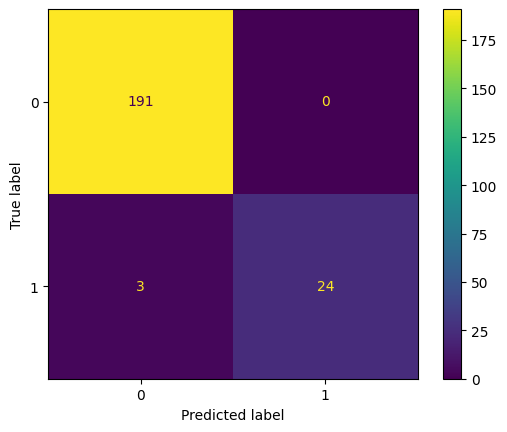

In [17]:
''' it will predict perfectly since it was trained on it '''
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

### Out of Bag Error - OOB

In [18]:
no_cv_oob = gscv_fit.best_estimator_.oob_score_
print('Out of Bag Score is:', no_cv_oob)
print('Out of Bag Error is:', 1 - no_cv_oob)

NameError: name 'gscv_fit' is not defined

# Cross Validation

Now let us use Cross Validation to Split the dataset and train with 3-fold CV

### First split the data 3 ways

In [ ]:
''' First split the data 3 ways '''

first_third = df.iloc[:df.shape[0]//3]
second_third = df.iloc[df.shape[0]//3 : 2*df.shape[0]//3]
third_third = df.iloc[df.shape[0]//3*2 : ]
print('Checking to make sure all thirds add up to the total')
print('sum of thirds', first_third.shape[0] + second_third.shape[0] + third_third.shape[0])
print('total', df.shape[0])

In [ ]:
grid_ranges = {
    'n_estimators': [500, 1000],
    'max_features': np.arange(target_max_features - 5, target_max_features + 5, 1),
    'bootstrap': [True],
    'oob_score': [True]
    #'random_state': [1] # maybe needed
}
clf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=grid_ranges,
    cv=3,
    n_jobs=-1,
    verbose=1
)

## First CV

### Trainning on first Two-folds

In [ ]:
display.Image('./first_fold.png')

In [ ]:
''' Trainning on First Two Folds '''
x_train = pd.concat([first_third, second_third]).drop('Label', axis=1)
y_train = pd.concat([first_third, second_third])['Label']
clf.fit(x_train , y_train)

### Testing on 3rd Fold

In [ ]:
first_predictions = clf.predict(third_third.drop('Label', axis=1))

#### Matrix on first CV

In [ ]:
cm = confusion_matrix(third_third['Label'], first_predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

#### Metrics

In [ ]:
first_accuracy_score = accuracy_score(first_predictions, third_third['Label'])
print('Accuracy Score', first_accuracy_score)

#### Out of Bag Error

In [ ]:
first_oob = clf.best_estimator_.oob_score_
first_oob

## Second CV

### Trainning on first and third fold

In [ ]:
display.Image('./second_cv.png')

In [ ]:
''' Trainning on First and Third Folds '''
x_train = pd.concat([first_third, third_third]).drop('Label', axis=1)
y_train = pd.concat([first_third, third_third])['Label']
clf.fit(x_train, y_train) # refitting actually untrains previous fit

### Testing on 2nd Fold

In [ ]:
second_predictions = clf.predict(second_third.drop('Label', axis=1))

### Metrics

#### Confusion Matrix

In [ ]:
cm = confusion_matrix(second_third['Label'], second_predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [ ]:
second_accuracy_score = accuracy_score(second_predictions, second_third['Label'])
print('accuracy_score', second_accuracy_score)

#### Out of Bag Error

In [ ]:
second_oob = clf.best_estimator_.oob_score_
second_oob_eeror = 1 - second_oob
print('The oob score is:', second_oob)
print('The OOB error is:', second_oob_eeror)

## Third CV

### Trainning on second and third fold

In [ ]:
display.Image('./third_cv.png')

In [ ]:
''' Trainning on last Two Folds '''
x_train = pd.concat([second_third, third_third]).drop('Label', axis=1)
y_train = pd.concat([second_third, third_third])['Label']
clf.fit(x_train , y_train)

### Testing on 1st Fold

In [ ]:
third_predictions = clf.predict(first_third.drop('Label', axis=1))

#### Confusion Matrix

In [ ]:
cm = confusion_matrix(first_third['Label'], third_predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

#### Metrics

In [ ]:
third_accuracy_score = accuracy_score(third_predictions, first_third['Label'])
print('Accuracy Score', third_accuracy_score)

In [ ]:
third_oob = clf.best_estimator_.oob_score_
print('The OOB score is:', third_oob)
print('The OOB Error is :,', 1 - third_oob)

## Metrics of all Three folds

### Average Accuracy Score

In [ ]:
average_accuracy = (first_accuracy_score + second_accuracy_score + third_accuracy_score)/3
print('Average Accuracy', average_accuracy)

### Average OOB Score vs No CV OOB Score

In [ ]:
average_oob = (first_oob + second_oob + third_oob)/3
print('Average oob of all 3 folds:', average_oob)
print('Average oob when trained on entire dataset:', no_cv_oob)
print('Wow! They are exactly the same! This shows that RF has built in CV')

### Taking a single positive and negative sample

#### Negative Sample

In [ ]:
index = 0 # index of sample to predict
single_sample = [x_test.iloc[index].to_numpy()]


In [ ]:
%%time
with warnings.catch_warnings(record=True):
    single_predict = model.predict(single_sample)

In [ ]:
print('predicted:', single_predict[0], ' actual', y_test[index])

#### Positive Sample

In [ ]:
index = 1 # index of sample to predict
single_sample = [x_test.iloc[index].to_numpy()]

In [ ]:
%%time
with warnings.catch_warnings(record=True):
    single_predict = model.predict(single_sample)

In [ ]:
print('predicted:', single_predict[0], ' actual', y_test[index])

In [ ]:
#predict = model.predict(x_test.iloc[0])
x_test.shape

# Cut Off
- Change the cutoff from anyhwere to 0 and 1
- The model should be already trained and is the variable 'model'
- The default value is 0.5

In [ ]:
cutoff = 0.5
y_pred_threshold = (model.predict_proba(x_test)[:, 1] > cutoff).astype('float')

# Confusion Matrix of the results with change in cutoff
confusion_matrix(y_test, y_pred_threshold)

In [ ]:
model.predict_proba(x_test)[0:10] # proportion of votes for each sample

# Metrics

### Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### Accuracy

In [ ]:
ac = accuracy_score(predict, y_test)
print('Accuracy is:', ac)

### Classification

Report, precision, recall, f1-score, support, accuracy

In [ ]:
from sklearn.metrics import classification_report
labels = ['class 0', 'class 1']
print(classification_report(y_test, predict, target_names=labels))

### The out of bag error, OOB

In [ ]:
print('The out of bag error is', model.oob_score_)

### Feature Ranking

In [ ]:
''' First extracting feature rankings and standardizing '''
# Standardize Importances
#std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
std = model.feature_importances_
feature_names = list(x_train.columns)
features_dict = {key: val for key, val in zip(feature_names, std)}
feature_rankings = {k: v for k, v in sorted(features_dict.items(), key=lambda item: item[1], reverse=True)}
feature_rankings_list = list(feature_rankings.items())

#### Plotting the Feature Ranking

In [ ]:
import matplotlib.pyplot as plt

# number of features to compare

n = 10
target_features = feature_rankings_list[:n]
feature_names = [tup[0] for tup in target_features]
feature_values = [tup[1] for tup in target_features]

fig = plt.figure(figsize = (10, 5))

plt.xticks(rotation=45, ha='right')

# creating the bar plot
plt.bar(feature_names, feature_values, color ='maroon',
        width = 0.4)

plt.xlabel('Feature')
plt.ylabel('Rank Normalized [0, 1]')
plt.title(f'Feature Ranking first {n}')

plt.show()
           

In [ ]:
import matplotlib.pyplot as plt

# number of features to compare

n = 30
target_features = feature_rankings_list[:n]
feature_names = [tup[0] for tup in target_features]
feature_values = [tup[1] for tup in target_features]

fig = plt.figure(figsize = (10, 5))

plt.xticks(rotation=45, ha='right')

# creating the bar plot
plt.bar(feature_names, feature_values, color ='maroon',
        width = 0.4)

plt.xlabel('Feature')
plt.ylabel('Rank Normalized [0, 1]')
plt.title(f'Feature Ranking first {n}')

plt.show()
           

# References

https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

I also referenced quickly many stack overflow posts